


# PyTorch Basics

I'll assume that everyone is familiar with Python. Training neural nets in bare Python is somewhat painful, but fortunately there are several well-established libraries which can help. I like PyTorch, which is built upon an earlier library called Torch. (There are many others, including TensorFlow and Jax, both of which I would encourage you to explore at your leisure.)


In [ ]:
import numpy as np
import torch
import torchvision

Torch believes that everything is a *tensor*.

In [ ]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.36886509 0.71902655 0.21237602]
 [0.08664056 0.92586243 0.75731764]]
tensor([[0.3689, 0.7190, 0.2124],
        [0.0866, 0.9259, 0.7573]], dtype=torch.float64)


The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon we will see that training neural nets basically involves *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about Torch variables is that they (natively) can be differentiated. (Again, we will see why this is important when we learn about backpropagation in deep learning.) 

In [ ]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1,requires_grad=True)

y = torch.matmul(A,x) + b

print(y)

tensor([[1.6215],
        [1.5528]], grad_fn=<AddBackward0>)


In [ ]:
z = y.sum()
print(z)

tensor(3.1743, grad_fn=<SumBackward0>)


Here, *z* is a function of the input *x*. Let us now compute the derivative of *z* with respect to *x* using backpropagation.

In [ ]:
z.backward()
print(x.grad)
print(x)

tensor([[1.4711],
        [1.1740]])
tensor([[0.8120],
        [0.8263]], requires_grad=True)


# Training simple models

OK, enough background. Let us now train a simple model. We will train a logistic classifier (equivalent to a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. (TorchVision has several other image datasets which we can directly load as variables, feel free to train your own models on them). 

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's quickly check that everything has been downloaded.

In [ ]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Some of you might know that this is the same size as the (very commonly used) MNIST dataset. Let's plot some images.

In [ ]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the 'image' object since it is a Torch tensor, so let's convert it back into a numpy array before displaying it. We will use matplotlib to show images.

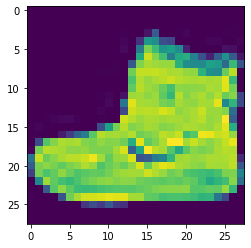

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

OK, that kinda sorta looks like a shoe? FashionMNIST is basically a bunch of black-white thumbnail images of different pieces of clothing. Let's try and plot a few of them. To step through the dataset, it will be helpful to construct a *data loader* object; we will use this while training our model below as well.

In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's now use the DataLoader object to spit out a few images from the dataset.

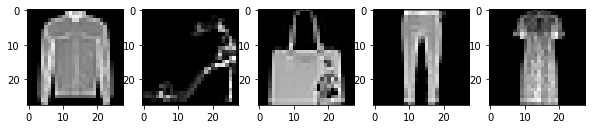

In [ ]:
images, labels = iter(trainDataLoader).next()

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

OK! Time to set up our model. 

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Cool! Everything is set up. Let's now train our network.

In [ ]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.9628831866199273, Test loss 0.7384625394253215
Epoch 1, Train loss 0.669227090471589, Test loss 0.6481344644810744
Epoch 2, Train loss 0.6048530459658169, Test loss 0.6072135472753245
Epoch 3, Train loss 0.569712356558995, Test loss 0.5793859970038104
Epoch 4, Train loss 0.5466805504583346, Test loss 0.5610787272453308
Epoch 5, Train loss 0.5301150181717964, Test loss 0.5491215814450744
Epoch 6, Train loss 0.517360219346689, Test loss 0.5395579376038472
Epoch 7, Train loss 0.5070971899640078, Test loss 0.53012230726564
Epoch 8, Train loss 0.4986808753248725, Test loss 0.5227101813456055
Epoch 9, Train loss 0.4913868474871365, Test loss 0.5153622133716657
Epoch 10, Train loss 0.48511413920090907, Test loss 0.51091866508411
Epoch 11, Train loss 0.4795060167942983, Test loss 0.5053211141164136
Epoch 12, Train loss 0.4750948576911934, Test loss 0.5025345730553766
Epoch 13, Train loss 0.47048642020871134, Test loss 0.5005893255494962
Epoch 14, Train loss 0.466834600006

Let's see how we did! We have tracked the losses so let's plot it.

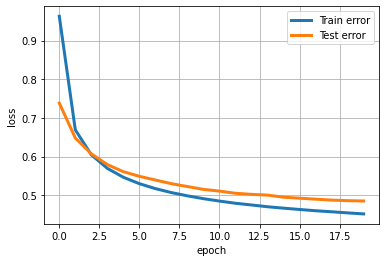

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Not too bad (although more epochs would have helped, I suppose). Let's evaluate our final model on a few more images to wrap things up.

In [ ]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)
print(fit)

torch.return_types.max(
values=tensor([ 6.0992,  2.8152,  8.9309,  7.8008,  6.4660,  5.8649, 10.1909,  4.3178,
         6.8928, 11.3527, 10.3758, 10.0492,  6.7620,  4.6565,  9.3138,  4.4809],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
tensor(0.3159, device='cuda:0', grad_fn=<NllLossBackward>)


Cool, looks like 2 images in this batch are being misclassified; can you (as a human) guess what those are?

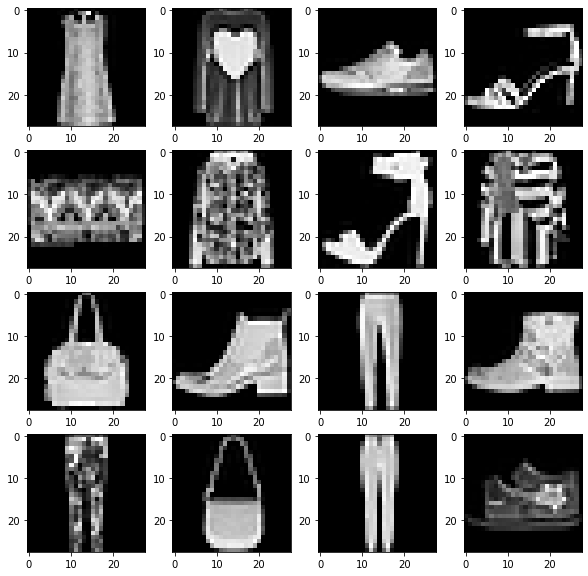

In [ ]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)